# Forecasting with LSTM multivariate

### Import libraries

In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pytagi import Normalizer as normalizer
import pytagi.metric as metric

### Import from Canari

In [2]:
from canari import (
    DataProcess,
    Model,
    plot_data,
    plot_prediction,
    plot_states,
)
from canari.component import LocalTrend, LstmNetwork, WhiteNoise

/opt/miniconda3/envs/canari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-28 15:44:55,955	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-28 15:44:56,031	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Read data

In [3]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data/toy_time_series/sine.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
# Add a trend to the data
linear_space = np.linspace(0, 2, num=len(df))
df = df.add(linear_space, axis=0)
#
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")
time_index = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_index = pd.to_datetime(time_index[0])
df.index = time_index
df.index.name = "time"
df.columns = ["values"]
df.head()

,values
time,
2000-01-03 00:00:00,0.000000
2000-01-03 01:00:00,-0.250698
2000-01-03 02:00:00,-0.481395
2000-01-03 03:00:00,-0.682093
2000-01-03 04:00:00,-0.832791


### Add dependent variables

In [4]:
# Add columns with lagged values
lag = [2]
df = DataProcess.add_lagged_columns(df, lag)

# Add moving average 
df['Moving_Average'] =  df['values'].rolling(window=3).mean()
df.head()

,values,values_lag1,values_lag2,Moving_Average
time,,,,
2000-01-03 00:00:00,0.000000,0.000000,0.000000,NaN
2000-01-03 01:00:00,-0.250698,0.000000,0.000000,NaN
2000-01-03 02:00:00,-0.481395,-0.250698,0.000000,-0.244031
2000-01-03 03:00:00,-0.682093,-0.481395,-0.250698,-0.471395
2000-01-03 04:00:00,-0.832791,-0.682093,-0.481395,-0.665426


### Data preprocess

In [5]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    train_split=0.8,
    validation_split=0.1,
    output_col=output_col,
)
train_data, validation_data, test_data, standardized_data = data_processor.get_splits()

### Define model from components

In [6]:
local_trend = LocalTrend()
pattern = LstmNetwork(
        look_back_len=19,
        num_features=4,  # number of data's columns + time covariates
        num_layer=1,
        num_hidden_unit=50,
        device="cpu",
        manual_seed=1,
    )
residual = WhiteNoise(std_error=0.05)

model = Model(local_trend, pattern, residual)
model.auto_initialize_baseline_states(train_data["y"][0 : 24])

### Training model,  i.e. LSTM neural network

In [7]:
num_epoch = 50
for epoch in range(num_epoch):
    (mu_validation_preds, std_validation_preds, states) = model.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )

    # Unstandardize the predictions
    mu_validation_preds = normalizer.unstandardize(
        mu_validation_preds,
        data_processor.scale_const_mean[output_col],
        data_processor.scale_const_std[output_col],
    )
    std_validation_preds = normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.scale_const_std[output_col],
    )

    # Calculate the log-likelihood metric
    validation_obs = data_processor.get_data("validation").flatten()
    mse = metric.mse(mu_validation_preds, validation_obs)

    # Early-stopping
    model.early_stopping(evaluate_metric=mse, current_epoch=epoch, max_epoch=num_epoch)
    if epoch == model.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds
        std_validation_preds_optim = std_validation_preds
        states_optim = copy.copy(
            states
        )
        lstm_optim_states = model.lstm_net.get_lstm_states() 

    model.set_memory(states=states, time_step=0)
    if model.stop_training:
        break

### Set relevant variables for predicting in the test set

In [8]:
model.lstm_net.set_lstm_states(lstm_optim_states)
model.states = states_optim
model.set_memory(
    states=states_optim,
    time_step=data_processor.test_start,
)

### Forecast on the test set

In [9]:
mu_test_preds, std_test_preds, states = model.forecast(
    data=test_data,
)

# Unstandardize the predictions
mu_test_preds = normalizer.unstandardize(
    mu_test_preds,
    data_processor.scale_const_mean[output_col],
    data_processor.scale_const_std[output_col],
)
std_test_preds = normalizer.unstandardize_std(
    std_test_preds,
    data_processor.scale_const_std[output_col],
)

### Predictions and hidden states

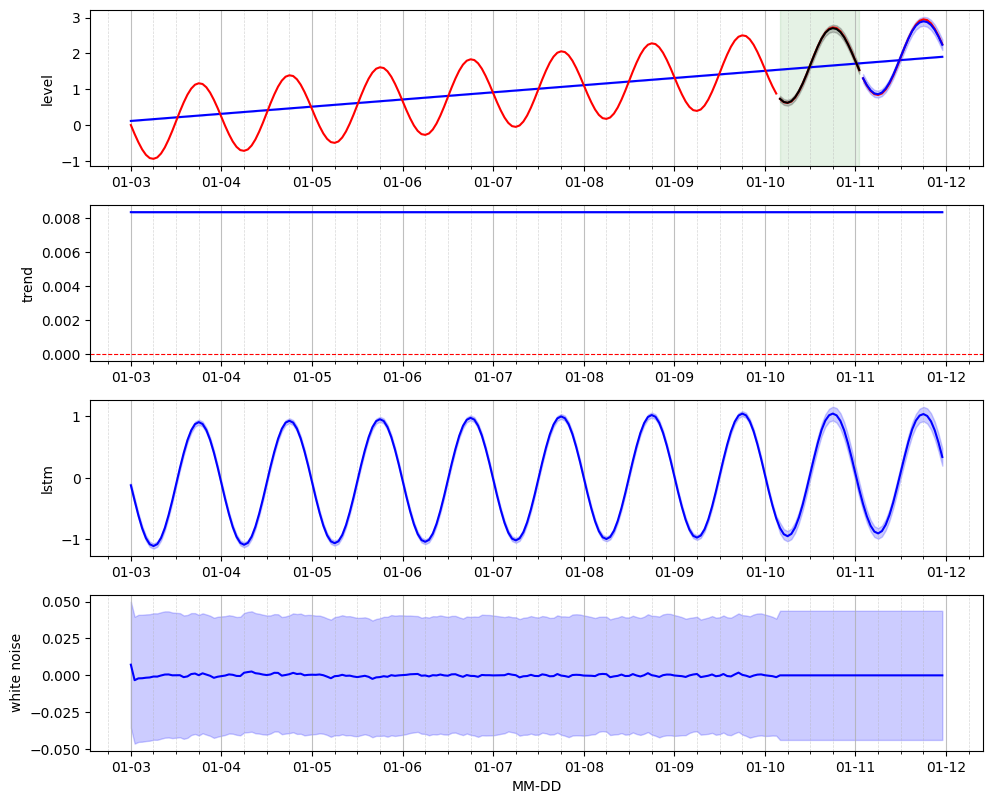

In [10]:
fig, ax = plot_states(
    data_processor=data_processor,
    states=states,
    )
plot_data(
    data_processor=data_processor,
    plot_train_data=True,
    plot_test_data=True,
    plot_validation_data=True,
    sub_plot=ax[0]
    )
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds,
    std_validation_pred = std_validation_preds,
    sub_plot=ax[0],
    color="k",
    )
plot_prediction(
    data_processor=data_processor,
    mean_test_pred=mu_test_preds,
    std_test_pred = std_test_preds,
    sub_plot=ax[0],
    color="b",
    )
ax[-1].set_xlabel("MM-DD") 
plt.show()